In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model

In [2]:
input_shape = (128, 128, 3)
data_dir = './dfdc_data/train_sample_videos/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = np.array(Y)
# Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [5]:
model_inception_resnet_v2 = load_model('deepfake-detection-model.h5')
model_inception_resnet_v2.load_weights('deepfake-detection-model.h5')
model_inception_resnet_v2

In [10]:
model_xceptionnet = load_model('deepfake-xception-model.h5')
model_xceptionnet.load_weights('deepfake-xception-model.h5')
model_xceptionnet

In [8]:
Y_val_pred_incp = model_inception_resnet_v2.predict_classes(X_val)

In [11]:
Y_val_pred_xcp = model_xceptionnet.predict_classes(X_val)

In [13]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

True positive =  559
False positive =  30
False negative =  46
True negative =  114




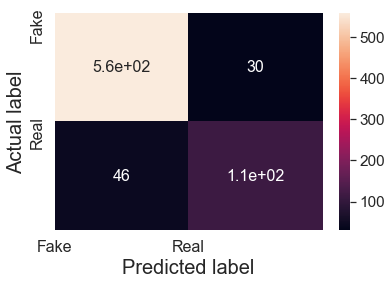

In [14]:
print_confusion_matrix(Y_val, Y_val_pred_incp)

True positive =  588
False positive =  1
False negative =  151
True negative =  9




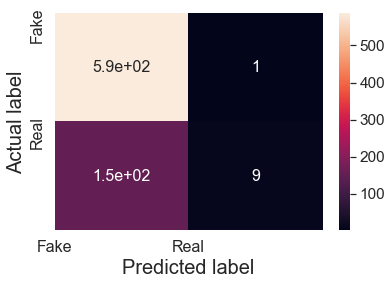

In [15]:
print_confusion_matrix(Y_val, Y_val_pred_xcp)

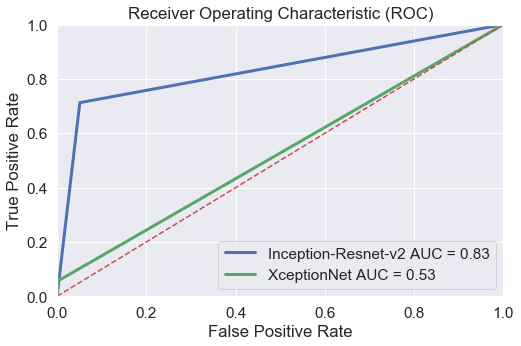

In [41]:
# ROC Curves for Inception-Resnet-v2 and XceptionNet
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (8,5)

fpr_incp, tpr_incp, threshold_incp = metrics.roc_curve(Y_val, Y_val_pred_incp)
roc_auc_incp = metrics.auc(fpr_incp, tpr_incp)

fpr_xcp, tpr_xcp, threshold_incp = metrics.roc_curve(Y_val, Y_val_pred_xcp)
roc_auc_xcp = metrics.auc(fpr_xcp, tpr_xcp)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr_incp, tpr_incp, 'b', linewidth = 3 ,label = 'Inception-Resnet-v2 AUC = %0.2f' % roc_auc_incp)
plt.plot(fpr_xcp, tpr_xcp, 'g', linewidth = 3, label = 'XceptionNet AUC = %0.2f' % roc_auc_xcp)

plt.legend(loc = 'lower right', )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("combined_roc_plot.png", dpi = 150)

plt.show()

In [38]:
# To save ong in an Excel file 
# but png itself worked

from PIL import Image

file_in = "combined_roc_plot.png"
img = Image.open(file_in)
file_out = 'test1.bmp'
print(len(img.split())) # test
if len(img.split()) == 4:
    # prevent IOError: cannot write mode RGBA as BMP
    r, g, b, a = img.split()
    img = Image.merge("RGB", (r, g, b))
    img.save(file_out)
else:
    img.save(file_out)

from xlwt import Workbook
w = Workbook()
ws = w.add_sheet('ROC Curve Image')
ws.insert_bitmap(file_out, 1, 0)
w.save('images.xls')

# import openpyxl

# wb = openpyxl.load_workbook('input.xlsx')
# ws = wb.active

# img = openpyxl.drawing.image.Image('combined_roc_plot.png')
# img.anchor(ws.cell('A1'))

# ws.add_image(img)
# wb.save('output.xlsx')

4
